# Detecting Pigs and the Swedish Chef based on audio and visual features

This notebook documents our approach to detect Pigs and the Swedish Chef based on feature-engineering for both modalities.  
We employ a Gaussian Mixture Model Classifier to predict the characters based on different video and audio-engineering features used for the different characters.

## Time sheet for this notebook

**Daniel Blasko:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>09.01.2024</td>
    <td>Setup notebook structure, load audio data and prepare the classifier - make the notebook ready so that only merging visual features is missing.</td>
    <td>2</td>
  </tr>
  <tr>
    <td>09.01.2024</td>
    <td>Experiment with Gaussian Mixture Models.</td>
    <td>2</td>
  </tr>
  <tr>
    <td>14.01.2024</td>
    <td>Integrate Alina's audio features into the notebook, tune and train the classifier, evaluate and comment the results.</td>
    <td>4</td>
  </tr>

</tbody>
</table>

**Alina Ehart:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  
</tbody>
</table>


## Imports


In [ ]:
!pip install -r ../requirements.txt


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)
from sklearn.mixture import GaussianMixture


import sys

sys.path.append("..")
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)

## Loading both sets of features and merging them into one dataframe


In each notebook for audio/vision, we have created a dataframe with the features fed into the classifier and exported it as a csv file. We will now load both csv files and merge them into one dataframe for the hybrid classifier.


In [2]:
vision_df = pd.read_csv("../results/sim2_visual/all.csv")

In [3]:
audio_df = pd.read_csv("../results/sim2_audio/audio_features.csv")

In [4]:
dataset = audio_df.merge(vision_df, on=["video_idx", "frame_idx"], how="inner")

Sanity check:


In [5]:
assert dataset.shape[0] == audio_df.shape[0] == vision_df.shape[0]

In [7]:
dataset.drop(columns=["Unnamed: 0_x"], axis=1, inplace=True)

## Splitting the data and aggregating the labels


For the hybrid classifier, we want to detect if the character is present at a given frame whether it is through audio or visual features. Therefore, we will aggregate the labels for each frame by merging the visual and audio flags (when both are available, which is not the case for Kermit) into a single one.


In [15]:
dataset["Pigs"] = dataset["Pigs"] + dataset["Audio_Pigs"]
dataset["Cook"] = dataset["Cook"] + dataset["Audio_Cook"]
dataset["Pigs"].replace(2, 1, inplace=True)
dataset["Cook"].replace(2, 1, inplace=True)
dataset.drop(columns=["Audio_Pigs", "Audio_Cook"], inplace=True)

And then split our data and prepare it for the classifier:


In [16]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another

In [17]:
# We extract the `X` and `y` matrices for the model, and then split into train and test sets by a 80/20 ratio
X = dataset.drop(columns=["Pigs", "Cook", "video_idx", "frame_idx"])
X.fillna(0, inplace=True)
y = dataset[["Pigs", "Cook"]]

In [18]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

Converting the one-hot-encoded labels into a single class column:  
Right now, the `y` matrix one-hot encodes the labels, but we need to convert it to a single column of labels for the classifier, where:

- 0: neither pigs nor the Swedish chef are present
- 1: Pigs are present
- 2: The Swedish chef is present
- 3: both are present


In [20]:
y_train = np.argmax(y_train, axis=1) + np.any(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) + np.any(y_test, axis=1)

## Training the classifier


Initially, to use a complex classifier from the Sim2 lectures, we implemented a Gaussian Mixture Model Classifier. However, the performance of the model was poor. We therefore decided to leave the working implementation to show that we worked on the Gaussian Mixture Models, but use a Quadratic Discriminant Analysis Classifier for evaluation.

The following cell shows our implementation of Gaussian Mixture Models for this task: we train a GMM for each class (stored in `gmms`) and then predict the class with the highest probability for each frame, as implemented below. Our hypothesis is that they did not perform well because the features are not normally distributed, which is an assumption of the GMM classifier, and since in this setting we have a very large feature vector, the important features might be overshadowed by the less important ones in this setting.


In [40]:
# Create a GMM for each class
gmms = [
    GaussianMixture(n_components=2, reg_covar=1e-4, covariance_type="full").fit(
        X_train[y_train == i]
    )
    for i in range(3)
]


# Prediction function
def predict_gmm(data_point, gmms):
    scores = np.array([gmm.score_samples([data_point]) for gmm in gmms])
    return np.argmax(scores)


# Example prediction
new_data_point = X_test.iloc[0]
predicted_class = predict_gmm(new_data_point, gmms)
print(f"Predicted class for the data point is: {predicted_class} real is {y_test[0]}")

Predicted class for the data point is: 2 real is 0


/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/Users/daniel/miniforge3/envs/simmod/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


For the reasons explained above, for the final hybrid classifier, we decide to use a quadratic discriminant analysis classifier in addition to the gaussian mixture model classifier that will take features from both modalities as an input. Its hyperparameters will be tuned through grid search and cross-validation.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    "reg_param": [0, 0.1, 0.2, 0.5, 0.7, 1],
    "tol": [1],
}
grid_search = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid,
    cv=3,
    scoring="recall_weighted",
)  # We optimize for recall because in experiments, false negatives were the biggest problem
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_lr.predict(X_test)

## Evaluating the classifier


In [42]:
# Convert labels for the first character
y_test_pigs = (y_test == 1) | (y_test == 3)
y_pred_pigs = (y_pred == 1) | (y_pred == 3)

# Convert labels for the second character
y_test_cook = (y_test == 2) | (y_test == 3)
y_pred_cook = (y_pred == 2) | (y_pred == 3)


# Compute metrics for the first character
accuracy_pigs = accuracy_score(y_test_pigs, y_pred_pigs)
precision_pigs = precision_score(y_test_pigs, y_pred_pigs)
recall_pigs = recall_score(y_test_pigs, y_pred_pigs)
f1_pigs = f1_score(y_test_pigs, y_pred_pigs)
map_pigs = average_precision_score(y_test_pigs, y_pred_pigs)

# Compute metrics for the second character
accuracy_cook = accuracy_score(y_test_cook, y_pred_cook)
precision_cook = precision_score(y_test_cook, y_pred_cook)
recall_cook = recall_score(y_test_cook, y_pred_cook)
f1_cook = f1_score(y_test_cook, y_pred_cook)
map_cook = average_precision_score(y_test_cook, y_pred_cook)

# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test, y_pred)
precision_general = precision_score(y_test, y_pred, average="weighted")
recall_general = recall_score(y_test, y_pred, average="weighted")
f1_general = f1_score(y_test, y_pred, average="weighted")

***General model metrics***
	Accuracy: 0.5095137420718816
	Precision: 0.8005103708733016
	Recall: 0.5095137420718816
	F1: 0.5861350192158695
***Pigs***
	Accuracy: 0.7704189498209432
	Precision: 0.4249206349206349
	Recall: 0.6118857142857143
	F1: 0.5015456674473069
	MAP: 0.33326515210002255
***Swedish chef***
	Accuracy: 0.6978470034948441
	Precision: 0.07646356033452807
	Recall: 0.9260450160771704
	F1: 0.14126302881667685
	MAP: 0.07279342519652367


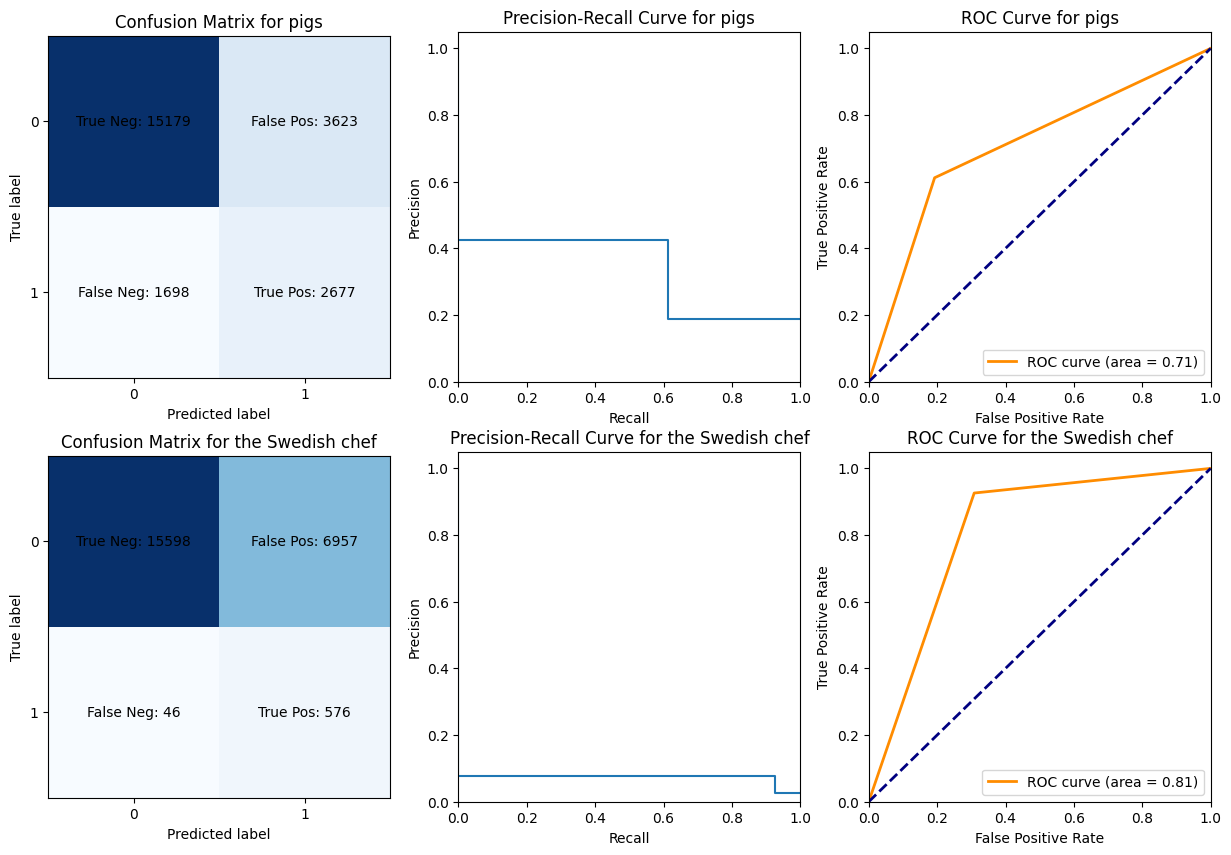

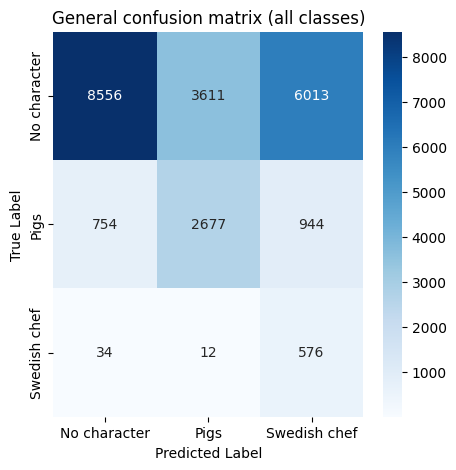

In [43]:
# *** Metrics ***
print(
    f"***General model metrics***\n\tAccuracy: {accuracy_general}\n\tPrecision: {precision_general}\n\tRecall: {recall_general}\n\tF1: {f1_general}"
)
print(
    f"***Pigs***\n\tAccuracy: {accuracy_pigs}\n\tPrecision: {precision_pigs}\n\tRecall: {recall_pigs}\n\tF1: {f1_pigs}\n\tMAP: {map_pigs}"
)
print(
    f"***Swedish chef***\n\tAccuracy: {accuracy_cook}\n\tPrecision: {precision_cook}\n\tRecall: {recall_cook}\n\tF1: {f1_cook}\n\tMAP: {map_cook}"
)

# *** Visual evaluation ***
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# Pigs
plot_confusion_matrix(
    y_test_pigs, y_pred_pigs, "Confusion Matrix for pigs", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test_pigs, y_pred_pigs, "Precision-Recall Curve for pigs", ax=axs[0, 1]
)
plot_roc_curve(y_test_pigs, y_pred_pigs, "ROC Curve for pigs", ax=axs[0, 2])
# Swedish chef
plot_confusion_matrix(
    y_test_cook,
    y_pred_cook,
    "Confusion Matrix for the Swedish chef",
    ax=axs[1, 0],
)
plot_precision_recall_curve(
    y_test_cook,
    y_pred_cook,
    "Precision-Recall Curve for the Swedish chef",
    ax=axs[1, 1],
)
plot_roc_curve(y_test_cook, y_pred_cook, "ROC Curve for the Swedish chef", ax=axs[1, 2])
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_global_confusion_matrix(
    y_test,
    y_pred,
    "Pigs",
    "Swedish chef",
)

## Analysis of the results


For the hybrid approach, we again combined the audio and visual features for each frame and trained a quadratic discriminant classifier on them. Gaussian mixture models were also implemented and tried, but final evaluation is done with the former due to performance limitations.  
In the audio/visual notebooks, the extracted features were stored in dataframes that were exported as csv files. We loaded these csv files and merged them into one dataframe for the hybrid classifier.  
We then randomly split the data into training and test sets (80/20%) and aggregated the labels for each frame by merging the visual and audio flags into a single one (overall presence of the character).

The final results of the hybrid classifier are shown in the first table below. The performance of the hybrid classifier is not ideal: while we expected the audio features to not improve the performance much in comparison to the visual classifier (which was already very good, and audio only performed poorly), we did not initially expect the global performance to be worse than with visual features only. The model has a tendency to over-predict positives for both classes, especially the Swedish Chef (high recall and low precision). We think there are two potential reasons for this: we use a different classifier than in the visual notebook, which might deal with this high-dimensional data worse, and/or the model learns from noise in the less-useful audio features.  
With further experiments, we found that it is a mixture of both hypotheses. As shown in the second table and figure below (_performance of the same classifier, but using the visual features only_), running the same model with only the visual data does improve performance (_so the added audio features turn out to be detrimental in this setup_), but it still performs worse than the classifier trained in the visual notebook (_the QDA classifier used here might be less powerful for this high-dimensional setup_).

Scaling the input significantly boosted performance here, most probably due to the different scales between visual and audio features. Hyperparameter tuning (here tuning the regularization parameter) was also important: best performance is obtained with no regularization at all, and even then, the model still is not ideal. We hypothethize that this is due to the large amount of features that the model does not handle perfectly and it is not powerful enough to overfit on this high-dimensional data.

**Performance of the hybrid classifier:**

<table>
<thead>
  <tr>
    <th><b>Experiment</b></th>
    <th><b>F1</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Pigs detection</b></td>
    <td>0.5015</td>
    <td>0.7704</td>
    <td>0.4249</td>
    <td>0.6119</td>
  </tr>
  <tr>
    <td><b>Swedish Chef detection</b></td>
    <td>0.1413</td>
    <td>0.6978</td>
    <td>0.0765</td>
    <td>0.926</td>

  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.5861</td>
    <td>0.5095</td>
    <td>0.8005</td>
    <td>0.5095</td>
  </tr>
</tbody>
</table>

<img src="../results/sim2_hybrid/results.png" style="max-width:75%; display: block; margin: 0 auto">

**Performance of the same hybrid classifier using only the visual features:**

<table>
<thead>
  <tr>
    <th><b>Experiment</b></th>
    <th><b>F1</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Pigs detection</b></td>
    <td>0.7143</td>
    <td>0.8681</td>
    <td>0.6011</td>
    <td>0.8800</td>
  </tr>
  <tr>
    <td><b>Swedish Chef detection</b></td>
    <td>0.9627</td>
    <td>0.9981</td>
    <td>0.9932</td>
    <td>0.9341</td>

  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.8752</td>
    <td>0.8666</td>
    <td>0.8984</td>
    <td>0.8666</td>
  </tr>
</tbody>
</table>

<img src="../results/sim2_hybrid/qda_visual_randomsplit.png" style="max-width:75%; display: block; margin: 0 auto">
